## Seminar 10. Introduction to Reinforcement Learning



In [ ]:
import sys, os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import random
%matplotlib inline

Let's delve into the foundational element of Reinforcement Learning (RL): the agent-environment interaction loop.

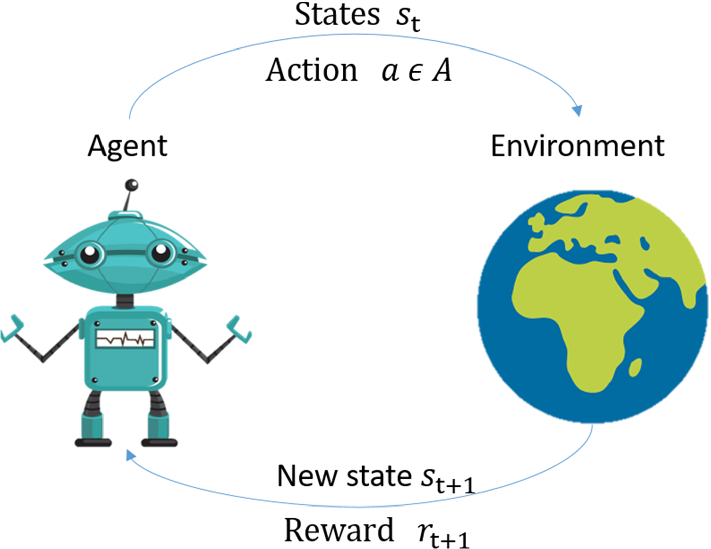

# 1. Basic Agent and Environment

To implement a reinforcement learning system, we must define both an **environment** and an **agent**. Usually, an environment has the following functions:



*   `__init__()`, i.e. a constructor.
*   `get_observation()` returns the current state observation.
*   `get_actions()`  provides the available actions for the agent.
*   `is_done()` signals episode end.
*    `action()` handles agent actions, returns a random reward, and updates the step counter, ending episodes when necessary.


Here is a basic environment that handles actions 0 and 1, operates for 10 time steps, and provides a random reward at each step.


In [ ]:
class Environment:
    def __init__(self):
        self.steps_left = 10

    def get_observation(self) -> List[float]:
        return [0.0, 0.0, 0.0]

    def get_actions(self) -> List[int]:
        return [0, 1]

    def is_done(self) -> bool:
        return self.steps_left == 0

    def action(self, action: int) -> float:
        if self.is_done():
            raise Exception("Game is over")
        self.steps_left -= 1
        return random.random()


An basic agent is much simpler and includes only two methods:

*   the constructor,
*   the `step()` function that performs one step in the environment.


The `step()` function  accepts the environment instance as an argument. On each step an agent:

1.  Observes the environment.
2.  Makes a decision about the action to take based on the observations.
3.  Submits the action to the environment.
4.  Gets the reward for the current step.







In [ ]:
class Agent:
    def __init__(self):
      self.total_reward = 0.0

    def step(self, env: Environment):
        current_obs = env.get_observation()
        print("Observation {}".format(current_obs))
        actions = env.get_actions()
        print("Actions {}".format(actions))
        reward = env.action(random.choice(actions)) # random action
        self.total_reward += reward

In [ ]:
env = Environment()
agent = Agent()

while not env.is_done():
    agent.step(env)

print("Total reward got: %.4f" % agent.total_reward)

# 2. NP problems

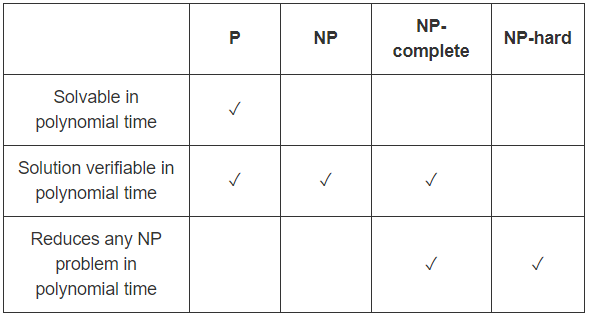

A potential application of RL algorithms in mathematics is the solution of NP problems. We will now consider a classical problem as an illustration.


> **Traveling Salesman Problem** (TSP). Given a complete weighted graph $G = (V, E)$, find a tour of minimum total weight, i.e. a cycle of minimum length that visits each node of the graph exactly once.

We'll generate a random graph with $N=7$ vertices. Existing edges have random weights from $1$ to $100$. Non-existent edges are assigned a large weight  $\operatorname{INF} = 10^5$, for completeness.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

# Large weight
INF_WEIGHT = 10**5

Graph generator

In [ ]:
def generate_graph_with_min_degree_2(num_vertices, prob=0.5):
  """Generates a graph where each vertex has a degree of at least 2."""
  graph = nx.Graph()
  for i in range(num_vertices):
      graph.add_node(i)

  # Random edges with probability prob
  for i in range(num_vertices):
    for j in range(i + 1, num_vertices):
      if random.random() < prob:  # Add an edge with probability prob
        weight = random.randint(1, 100)
        graph.add_edge(i, j, weight=weight)

  # Ensure min degree 2
  for i in range(num_vertices):
    if graph.degree[i] < 2:
      neighbors = list(graph.neighbors(i))
      if len(neighbors) == 0:
        other_nodes = [n for n in graph.nodes if n != i]
        if len(other_nodes) >= 2:
          weight = random.randint(1, 100)
          graph.add_edge(i, other_nodes[0], weight=weight)
          weight = random.randint(1, 100)
          graph.add_edge(i, other_nodes[1], weight=weight)
      elif len(neighbors) == 1:
        other_nodes = [n for n in graph.nodes if n != i and n not in neighbors]
        if len(other_nodes) >= 1:
          weight = random.randint(1, 100)
          graph.add_edge(i, other_nodes[0], weight=weight)

  return graph




def draw_graph(graph, inf_weight=INF_WEIGHT):
  """Draws the graph."""
  plt.figure(figsize=(8, 4))
  pos = nx.spring_layout(graph)

  # No edges with INF_WEIGHT
  edges_to_draw = [(u, v) for u, v, data in graph.edges(data=True) if data['weight'] != inf_weight]
  labels = {(u, v): data['weight'] for u, v, data in graph.edges(data=True) if data['weight'] != inf_weight}

  nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=500, edgelist=edges_to_draw,
          edge_cmap=plt.cm.Blues, width=2)
  nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
  plt.show()


def get_weight_matrix(graph):
  """Returns the weight matrix of the graph."""
  num_vertices = len(graph.nodes)
  weight_matrix = np.full((num_vertices, num_vertices), 10**5)  # Initialize with large weights

  for u, v, data in graph.edges(data=True):
    weight_matrix[u][v] = weight_matrix[v][u] = data['weight']

  for i in range(num_vertices):
    weight_matrix[i][i] = 0

  return weight_matrix

Generated graph

In [ ]:
# Fix the random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Generate a random graph with 7 vertices
num_vertices = 8
graph = generate_graph_with_min_degree_2(num_vertices, prob = 0.8)

# Draw the graph
draw_graph(graph)

# Print the weight matrix
weight_matrix = get_weight_matrix(graph)
print("Weight Matrix:")
weight_matrix

## 2.1 Brute-force solution

TSP problem is NP-hard. The best known exact algorithm is the Held-Karp algorithm [Held and Karp, 1962]. It solves the
problem in time $O\left(n^2 2^n \right)$ and (to the best of our knowledge) it has not been improved in the general setting since then. For details, see e.g.
"Reinforcement Learning for Combinatorial Optimization: A Survey" by
Nina Mazyavkina et al. https://arxiv.org/abs/2003.03600



In [ ]:
import itertools

def solve_tsp_brute_force(weight_matrix):
  """Solves the TSP using brute force."""
  num_vertices = len(weight_matrix)
  min_cost = float('inf')
  best_path = None

  for path in itertools.permutations(range(num_vertices)):
    cost = 0
    for i in range(num_vertices - 1):
      cost += weight_matrix[path[i]][path[i+1]]
    cost += weight_matrix[path[-1]][path[0]]  # Return to the starting city

    if cost < min_cost:
      min_cost = cost
      best_path = path

  return best_path, min_cost


# Solve the TSP using brute force
best_path, min_cost = solve_tsp_brute_force(weight_matrix)

print("Best path found:", best_path)
print("Minimum cost:", min_cost)


## 2.2 RL in Combinatorial Optimization problems

The next figure outlines reinforcement learning (RL) pipeline for combinatorial optimization (CO) problems.



*   Initially, the CO problem is transformed into a **Markov Decision Process** (MDP) by defining states, actions, and rewards.
*   Then, an **encoder** maps states to numerical vectors.
*   The core of the process is the **RL algorithm**, which teaches the agent how to optimize the encoder and make decisions in the MDP. The reward received after each action is used to update both the encoder and the MDP parameters.



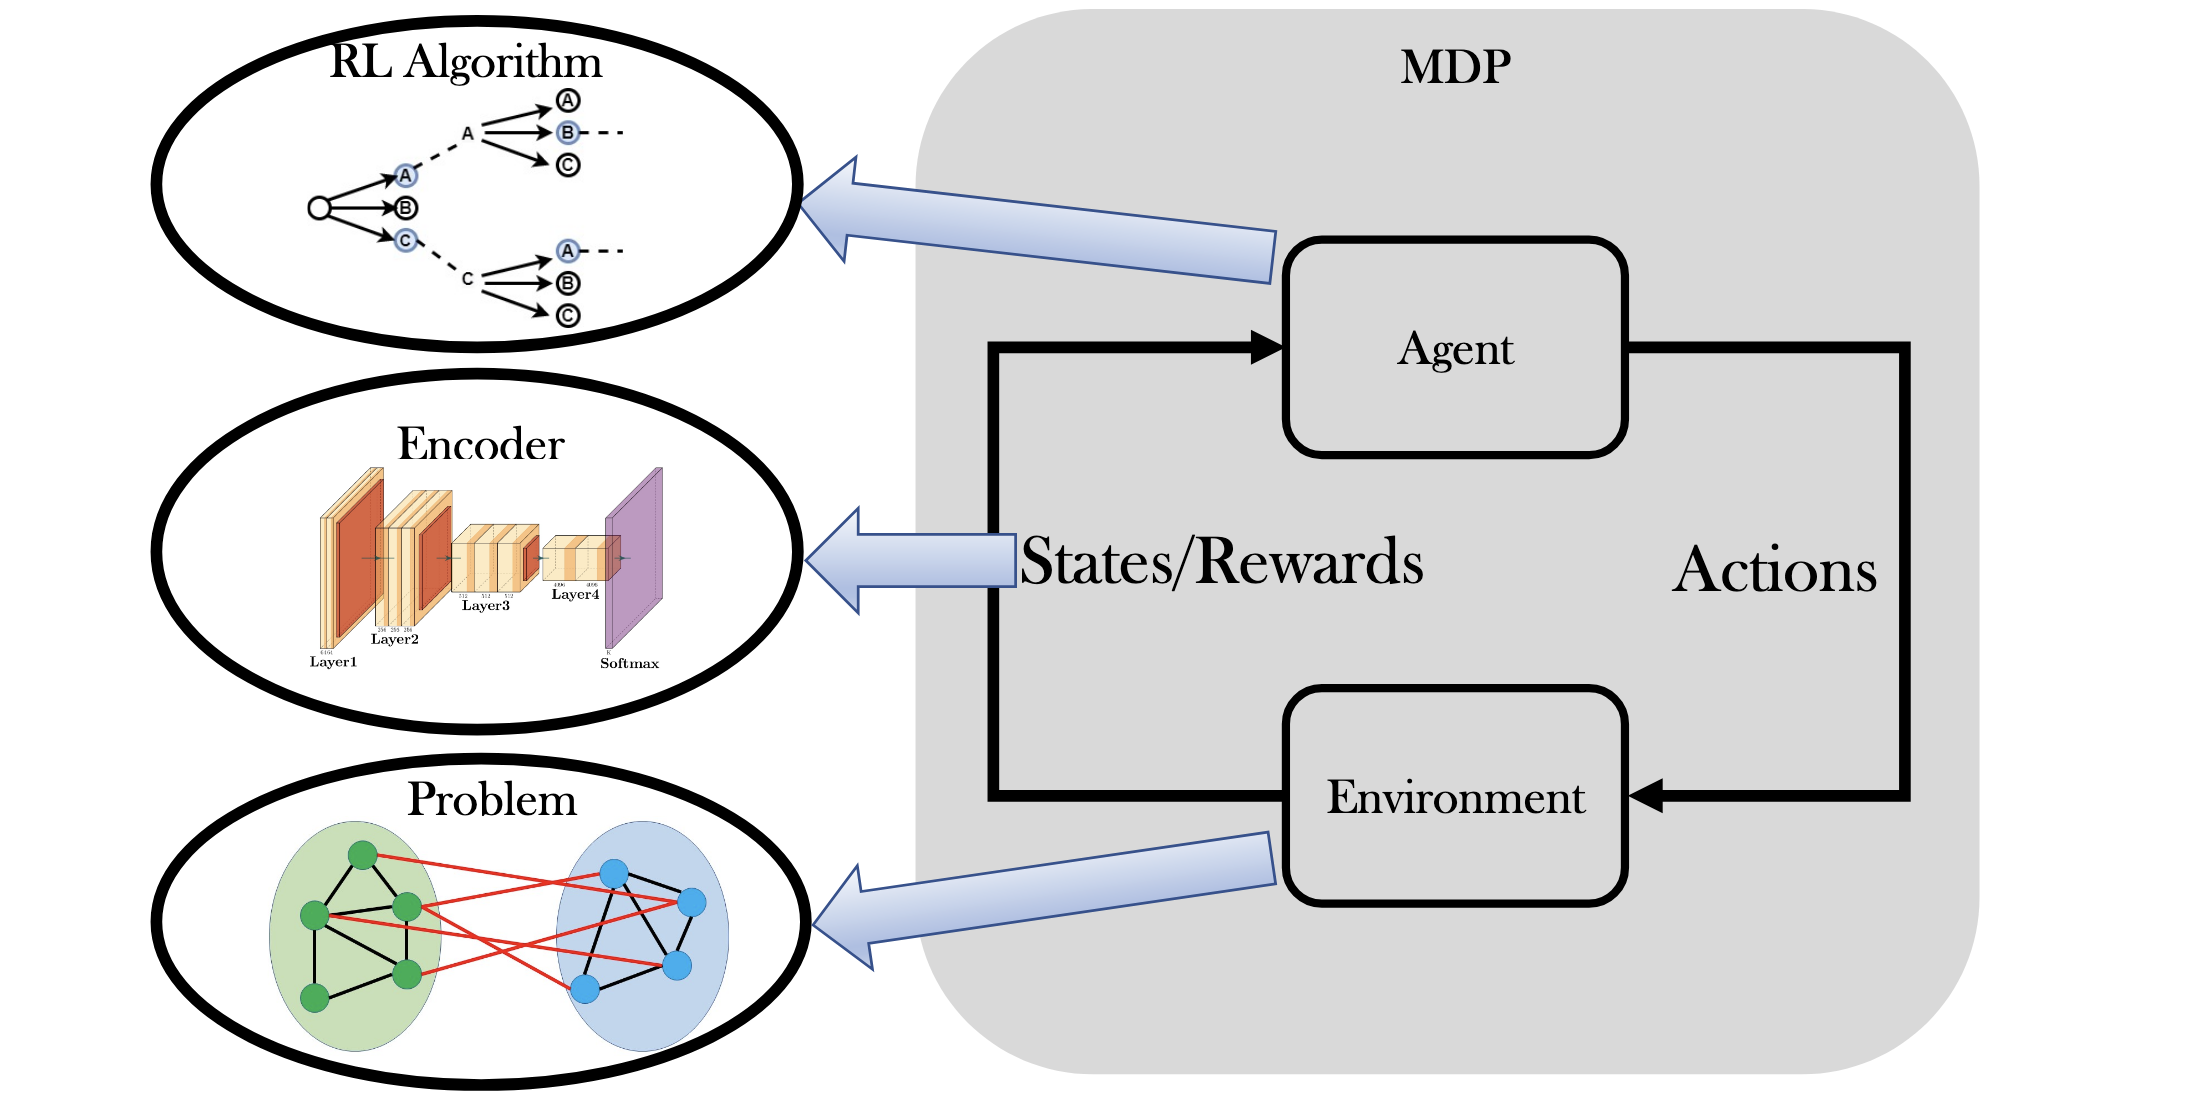

# 3. Cross-Entropy Method

We start with the **Cross-Entropy Method** in RL. Despite its simplicity, it works well in basic environments, it's easy to implement, and it's quite robust against changing hyperparameters, which often makes it an ideal baseline method.

The core of the cross-entropy method is to **throw away bad episodes and train on better ones**. So, the steps of the method are as follows:
1. Play N episodes using our current model and environment.
2. Calculate the total reward for every episode and decide on a reward boundary. Usually, we use a percentile of all rewards, such as the 50th or 70th.
3. Throw away all episodes with a reward below the boundary.
4. Train on the remaining ”elite” episodes (with rewards higher than the boundary) using observations as the input and issued actions as the desired output.
5. Repeat from step 1 until we become satisfied with the result.

The field of RL encompasses a wide array of methods. We'll now examine their different types.

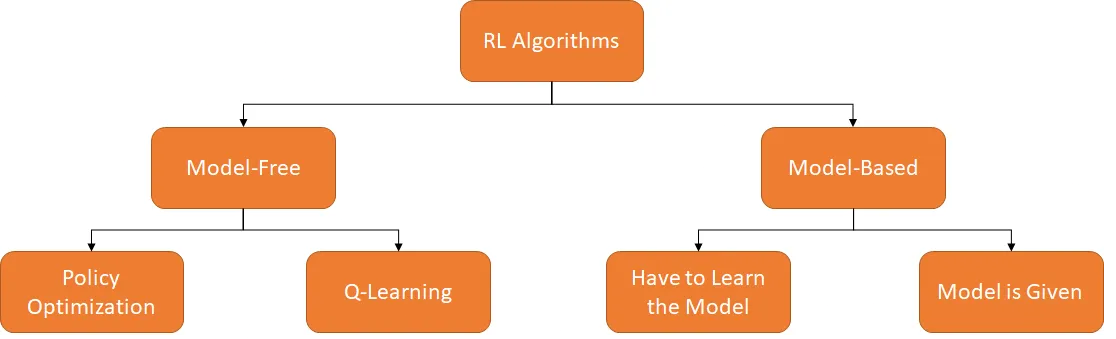

RL methods can be broadly divided into $2$ types:

1. **model-free**, which directly tells the agent what to do without modeling the environment
2. **model-based** (e.g. chess models, where we know the result of each move).


Model-based methods, though harder to train, typically yield superior results. Model-free methods are more versatile.

*   <font color='blue'>**Question**.</font> Is the Cross-Entropy method model-free or model based?


 Model-based methods  can be further divided into 2 categories:

1. **policy-based**, which focuses on approximating the agent's strategy.

2. **value-based**, which focuses on state evaluation.

*   <font color='blue'>**Question**.</font> Is the Cross-Entropy method policy-based or value-based?



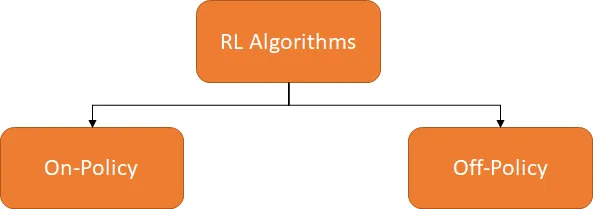

Another RL method division is

* **on-policy** methods, which requires fresh environment data,
* **off-policy** methods, which can utilize any available data.

*   <font color='blue'>**Question**.</font> Is the Cross-Entropy method on-policy or off-policy?

**Remark**. The explanation why CE method works can be found in the the original paper by Kroese , titled `Cross-entropy method` , https://doi.org/10.1002/9780470400531.eorms0210.

## 3.1 Cross-Entropy method for the Travelling Salesman Problem

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

A simple function that computes the total length of a tour.

In [ ]:
def compute_tour_length(tour, dist):
    # Compute the total length of a tour
    total_length = 0
    for i in range(len(tour)):
        start = tour[i]
        end = tour[(i + 1) % len(tour)]
        total_length += dist[start][end]
    return total_length

We use a simple RNN as an encoder.

In [ ]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RNNEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)

    def forward(self, x, hx=None):
        # x shape: (sequence_length, input_dim)
        output, hidden = self.rnn(x, hx)
        return output, hidden

### 3.1.1. Model

We employ a very simple model to predict the next vertex in a path:

*   TSPSolver = RNN + MLP (Linear-ReLU-Linear)

During the training the best paths are saved, and the model's parameters are updated to improve predictions of subsequent vertices based on prior ones.



In [ ]:
class TSPSolver(nn.Module):
    def __init__(self, num_cities, input_dim, hidden_dim):
        super(TSPSolver, self).__init__()
        self.encoder = RNNEncoder(input_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_cities)

        self.num_cities = num_cities

    def forward(self, coords, hx=None):
        # coords shape: (batch_size, num_cities, input_dim)
        encoded, hidden = self.encoder(coords, hx) # encoded shape: (batch_size, hidden_dim)
        x = F.relu(self.fc1(encoded)) # x shape: (batch_size, hidden_dim)
        logits = self.fc2(x) # logits shape: (batch_size, num_cities)
        return logits

    def sample_tour(self, weight_matrix, start_vertex=0, temperature=1.0):
        # Sampling a complete tour using the model's policy

        tour = [start_vertex]
        remaining = list(range(self.num_cities))
        remaining.remove(start_vertex)


        tour_tensor = torch.tensor([v for v in tour], dtype=torch.float32).unsqueeze(1)


        for _ in range(self.num_cities - 1):
            # Sample from current probabilities
            if len(remaining) == 1:
                city = remaining[0]
            else:
                #coords = weight_matrix[vertex,:]
                # coords_tensor shape = (1, num_cities)
                #coords_tensor = coords.clone().detach().unsqueeze(0)
                logits = self(tour_tensor)[-1,:] #logits shape = (1, num_cities)
                #logits shape = (1, hid_dim)
                # Get the correct shape of probs
                probs = F.softmax(logits / temperature, dim=-1).squeeze(0) # squeezing to remove the batch dimension
                city_probs = torch.zeros(len(remaining))

                for i, r in enumerate(remaining):
                    # Index probs correctly
                    city_probs[i] = probs[r]
                city_probs /= city_probs.sum()
                city = remaining[torch.multinomial(city_probs, 1).item()]
                tour_tensor = torch.tensor([v for v in tour], dtype=torch.float32).unsqueeze(1)


            tour.append(city)
            remaining.remove(city)

        return tour

### 3.1.2. CE method

In [ ]:
def cross_entropy_method(solver, weight_matrix, optimizer,
                         num_iterations=10, population_size=100, elite_fraction=0.2):

    # shape (num_cities, num_cities)
    weight_matrix_tensor = torch.tensor(weight_matrix, dtype=torch.float32)

    best_tour = None
    best_length = float('inf')

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    for iteration in range(num_iterations):
        # Generate a population of tours
        tours = []
        tour_lengths = []

        for _ in range(population_size):
            tour = solver.sample_tour(weight_matrix_tensor) # list with len = num_cities
            tour_length = compute_tour_length(tour, weight_matrix)

            tours.append(tour)
            tour_lengths.append(tour_length)


        # Select elite tours
        num_elite = int(population_size * elite_fraction)
        elite_indices = np.argsort(tour_lengths)[:num_elite]
        elite_tours = [tours[i] for i in elite_indices]
        worst_elite_tour=tour_lengths[elite_indices[-1]]

        # Update best solution
        current_best_length = min(tour_lengths)
        if current_best_length < best_length:
            best_length = current_best_length
            best_tour = tours[np.argmin(tour_lengths)]

        # Train the model on elite tours
        if elite_tours:
            # Reset gradients
            solver.zero_grad()


            for tour in elite_tours:
                for j in range(len(tour)-1):
                    # Prepare input data
                    input_sequence = torch.tensor([city for city in tour[:-1-j]],
                                                  dtype=torch.float32).unsqueeze(1)
                    target_city = torch.tensor(tour[-1-j], dtype=torch.long)

                    # Forward pass
                    output = solver(input_sequence)[-1,:]



                    # Calculate loss
                    loss = criterion(output, target_city)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

        if (iteration + 1) % 1 == 0:
            print(f"Iteration [{iteration+1}/{num_iterations}]")
            print(f"Worst Elite Tour: {worst_elite_tour}")
            print(f"Current Best Tour: {best_tour}")
            print(f"Current Tour Length: {best_length}")

    return worst_elite_tour, best_tour, best_length

### 3.3.3. Application of the model

Our model succefully solves the TSP for this small graph.

In [ ]:
def CE_TSP(num_cities=7, start_city=0, prob = 0.5):
    # Random city coordinates
    random.seed(42)
    np.random.seed(42)

    # Generate a random graph with 7 vertices
    graph = generate_graph_with_min_degree_2(num_cities, prob)
    draw_graph(graph)

    # Initialize solver
    INPUT_DIM = 1
    HIDDEM_DIM = 64
    solver = TSPSolver(num_cities, input_dim=INPUT_DIM, hidden_dim=HIDDEM_DIM)
    optimizer = optim.Adam(solver.parameters(), lr=3e-4)

    weight_matrix = get_weight_matrix(graph)

    # Solve TSP
    worst_best, best_tour, best_length = cross_entropy_method(solver, weight_matrix, optimizer, num_iterations=20, population_size=200, elite_fraction=0.05)

    print(f"Worst Elite Tour: {worst_best}")
    print(f"Best Tour: {best_tour}")
    print(f"Tour Length: {best_length}")

CE_TSP(num_cities=8, prob = 0.8)